In [36]:
# Install necessary libraries
!pip install opencv-python-headless tensorflow pandas numpy matplotlib seaborn scikit-learn


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [37]:
import pandas as pd
import os
import json
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Define paths
photo_path = "C:/Users/moksh/Downloads/Yelp-Photos/Yelp Photos/yelp_photos/photos"
photos_json_path = "C:/Users/moksh/Downloads/Yelp-Photos/Yelp Photos/yelp_photos/photos.json"  # Adjust the path to your JSON file

# Load JSON data (replace this with the actual JSON structure)
photos_df = pd.read_json(photos_json_path, lines=True)

# Inspect the first few rows
print(photos_df.head())

                 photo_id             business_id  \
0  zsvj7vloL4L5jhYyPIuVwg  Nk-SJhPlDBkAZvfsADtccA   
1  HCUdRJHHm_e0OCTlZetGLg  yVZtL5MmrpiivyCIrVkGgA   
2  vkr8T0scuJmGVvN2HJelEA  _ab50qdWOk0DdB6XOrBitw   
3  pve7D6NUrafHW3EAORubyw  SZU9c8V2GuREDN5KgyHFJw   
4  H52Er-uBg6rNrHcReWTD2w  Gzur0f0XMkrVxIwYJvOt2g   

                                             caption    label  
0  Nice rock artwork everywhere and craploads of ...   inside  
1                                                     outside  
2                                     oyster shooter    drink  
3                                      Shrimp scampi     food  
4                                                        food  


In [38]:
photos_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200100 entries, 0 to 200099
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   photo_id     200100 non-null  object
 1   business_id  200100 non-null  object
 2   caption      200100 non-null  object
 3   label        200100 non-null  object
dtypes: object(4)
memory usage: 6.1+ MB


In [40]:
photos_df['label' ].unique() 

array(['inside', 'outside', 'drink', 'food', 'menu'], dtype=object)

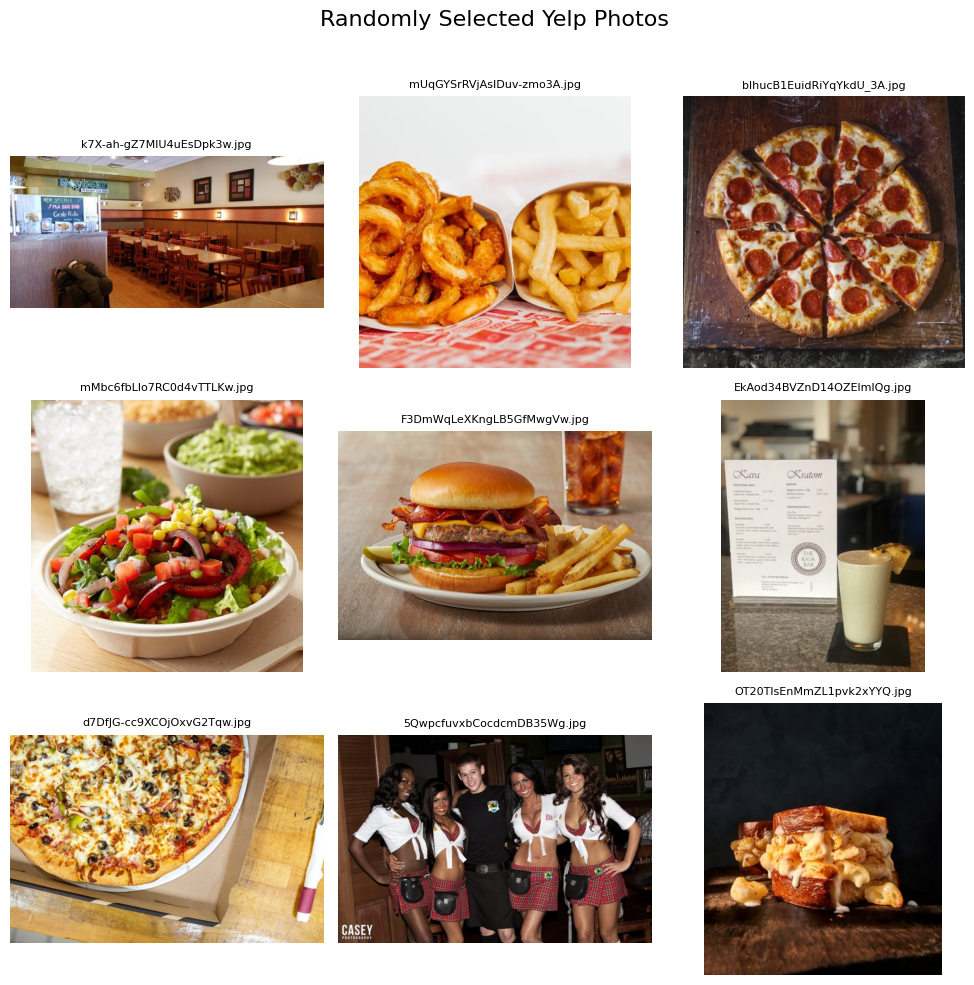

In [41]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Path to the folder containing the photos
#photos_folder = 'C:/Users/rinua/Downloads/Yelp-Photos/Yelp Photos/yelp_photos/photos'

# Get a list of all files in the folder
all_photos = os.listdir(photo_path)

# Filter out non-image files (optional, if needed)
image_files = [f for f in all_photos if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Pick 9 random images from the list
selected_photos = random.sample(image_files, 9)

# Create a 3x3 grid to display images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle("Randomly Selected Yelp Photos", fontsize=16)

# Loop through the selected photos and display them
for i, photo in enumerate(selected_photos):
    # Get the full path of the image
    img_path = os.path.join(photo_path, photo)
    img = Image.open(img_path)  # Open the image
    
    # Calculate the row and column to place the image in
    row, col = divmod(i, 3)
    
    # Display the image
    axes[row, col].imshow(img)
    axes[row, col].axis('off')  # Hide axes
    axes[row, col].set_title(photo, fontsize=8)  # Set the title of the image

# Adjust layout to prevent overlap of titles and images
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot with the images
plt.show()

### Looking at class distribution

C:\Users\moksh\AppData\Local\Temp\ipykernel_25720\447046137.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20", len(label_counts))  # Using a colormap (tab20) for distinct colors


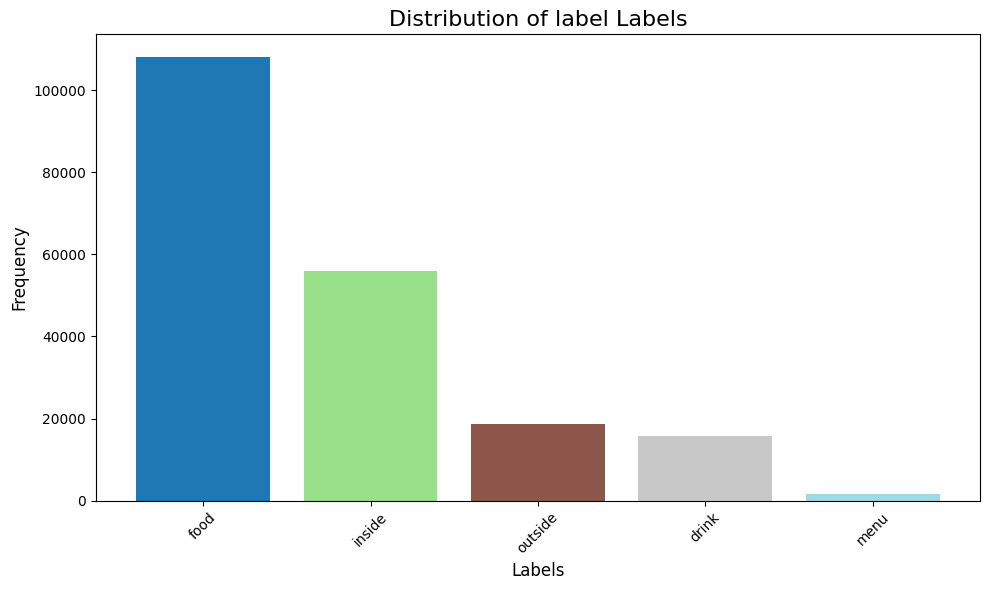

In [42]:
# Check the column names to identify the labels (assuming the column is named 'label' or similar)
if 'category' in photos_df.columns:
    label_column = 'category'
elif 'label' in photos_df.columns:
    label_column = 'label'
else:
    raise ValueError("The JSON file does not contain a label column.")

# Count the occurrences of each label
label_counts = photos_df[label_column].value_counts()

# Generate a list of unique colors (one for each bar)
colors = plt.cm.get_cmap("tab20", len(label_counts))  # Using a colormap (tab20) for distinct colors
color_list = [colors(i) for i in range(len(label_counts))]

# Plot the label distribution with different colors for each bar
plt.figure(figsize=(10, 6))
bars = plt.bar(label_counts.index, label_counts.values, color=color_list)

# Add title and labels
plt.title(f"Distribution of {label_column} Labels", fontsize=16)
plt.xlabel("Labels", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

### Creating a Train-Test split

In [43]:
from sklearn.model_selection import train_test_split

# Stratified split to keep label distribution, 10% sampled data
sampled_data_df, _ = train_test_split(photos_df, test_size=0.9, stratify=photos_df['label'])

# Convert sampled data to list of dicts with photo_id and label
sampled_data_list = sampled_data_df[['photo_id', 'label']].to_dict(orient='records')

print(f"Sampled data contains {len(sampled_data_list)} entries.")

# Create label_dict mapping label names to integers
unique_labels = photos_df['label'].unique()
label_dict = {label: idx for idx, label in enumerate(sorted(unique_labels))}
print(label_dict)

Sampled data contains 20010 entries.
{'drink': 0, 'food': 1, 'inside': 2, 'menu': 3, 'outside': 4}


### Resizing the images

In [44]:
import os
import cv2

# Target size for resizing images
TARGET_SIZE = (64, 64)

# Folder where the resized images will be saved
resized_folder = "C:/Users/moksh/Downloads/Yelp-Photos/Yelp Photos/resized_photos"
photos_folder = "C:/Users/moksh/Downloads/Yelp-Photos/Yelp Photos/yelp_photos/photos"  # Update this if needed

# Create the folder if it doesn't exist
os.makedirs(resized_folder, exist_ok=True)

# Track errors and successes
error_count = 0
processed_count = 0

for i, entry in enumerate(sampled_data_list):
    try:
        photo_id = entry['photo_id']
        img_path = os.path.join(photos_folder, photo_id + '.jpg')

        img = cv2.imread(img_path)

        if img is None:
            if error_count < 10:
                print(f"[Unreadable] {img_path}")
            error_count += 1
            continue

        img_resized = cv2.resize(img, TARGET_SIZE, interpolation=cv2.INTER_AREA)

        save_path = os.path.join(resized_folder, photo_id + '.jpg')
        cv2.imwrite(save_path, img_resized)

        processed_count += 1

        # Print progress every 500 images
        if processed_count % 500 == 0:
            print(f"{processed_count} images processed...")

    except Exception as e:
        if error_count < 10:
            print(f"[Error] {img_path}: {e}")
        error_count += 1

print(f"\n✅ Resizing completed: {processed_count} images processed, {error_count} errors.")

[Unreadable] C:/Users/moksh/Downloads/Yelp-Photos/Yelp Photos/yelp_photos/photos\9jBH61ndIcsheo6FtIHArA.jpg
500 images processed...
[Unreadable] C:/Users/moksh/Downloads/Yelp-Photos/Yelp Photos/yelp_photos/photos\1wd_eyhMrTqUmicDmn4_Kw.jpg
1000 images processed...
1500 images processed...
2000 images processed...
2500 images processed...
[Unreadable] C:/Users/moksh/Downloads/Yelp-Photos/Yelp Photos/yelp_photos/photos\WGmGujPl5BmR_fCUZnoe9w.jpg
3000 images processed...
3500 images processed...
4000 images processed...
4500 images processed...
[Unreadable] C:/Users/moksh/Downloads/Yelp-Photos/Yelp Photos/yelp_photos/photos\43fHlHSYQ_79OBJW1aVUxA.jpg
5000 images processed...
5500 images processed...
6000 images processed...
[Unreadable] C:/Users/moksh/Downloads/Yelp-Photos/Yelp Photos/yelp_photos/photos\yFjqHyOaNFwzIWTV8EE9hg.jpg
6500 images processed...
7000 images processed...
7500 images processed...
8000 images processed...
8500 images processed...
9000 images processed...
9500 images

### CNN usually works well with RGB data or non-thresholded grayscale data and color can be of significance for food classification. So instead of just looking at RGB and grayscaled data, I have tried other methods to understand the change in accuracy of model  
I have also compared the performance:
- grayscale + gaussian blur
- grayscale + histogram equalization
- grayscale + gaussian blur + histogram equalization

In [45]:
import os
import cv2
import numpy as np
from tqdm import tqdm

TARGET_SIZE = (64, 64)

def apply_preprocessing(img, method):
    if method == 'rgb':
        return img
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if method == 'grayscale':
        return gray
    elif method == 'grayscale_blur':
        return cv2.GaussianBlur(gray, (5, 5), 0)
    elif method == 'grayscale_eq':
        return cv2.equalizeHist(gray)
    elif method == 'grayscale_blur_eq':
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        return cv2.equalizeHist(blurred)
    else:
        raise ValueError("Invalid preprocessing method")

In [46]:
def generate_variants(sampled_data_list, input_folder, output_folder, method):
    os.makedirs(output_folder, exist_ok=True)
    for entry in tqdm(sampled_data_list):
        photo_id = entry['photo_id']
        input_path = os.path.join(input_folder, f"{photo_id}.jpg")
        output_path = os.path.join(output_folder, f"{photo_id}.jpg")

        img = cv2.imread(input_path)
        if img is None:
            continue

        img = cv2.resize(img, TARGET_SIZE)
        processed = apply_preprocessing(img, method)
        cv2.imwrite(output_path, processed)

In [47]:
methods = {
    'rgb': 'resized_photos',
    'grayscale': 'grayscale',
    'grayscale_blur': 'grayscale_blur',
    'grayscale_eq': 'grayscale_eq',
    'grayscale_blur_eq': 'grayscale_blur_eq',
}

for method, folder in methods.items():
    print(f"Processing: {method}")
    generate_variants(sampled_data_list, "C:/Users/moksh/Downloads/Yelp-Photos/Yelp Photos/resized_photos", 
                      f"C:/Users/moksh/Downloads/Yelp-Photos/Yelp Photos/{folder}", 
                      method)

Processing: rgb


100%|██████████████████████████████████████████████████████████████████████████| 20010/20010 [00:12<00:00, 1630.33it/s]


Processing: grayscale


100%|██████████████████████████████████████████████████████████████████████████| 20010/20010 [00:15<00:00, 1312.79it/s]


Processing: grayscale_blur


100%|███████████████████████████████████████████████████████████████████████████| 20010/20010 [00:24<00:00, 830.53it/s]


Processing: grayscale_eq


100%|██████████████████████████████████████████████████████████████████████████| 20010/20010 [00:14<00:00, 1383.36it/s]


Processing: grayscale_blur_eq


100%|███████████████████████████████████████████████████████████████████████████| 20010/20010 [00:24<00:00, 810.84it/s]


In [58]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Define method-to-folder mapping (dictionary)
methods = {
    'rgb': 'resized_photos',
    'grayscale': 'grayscale',
    'grayscale_blur': 'grayscale_blur',
    'grayscale_eq': 'grayscale_eq',
    'grayscale_blur_eq': 'grayscale_blur_eq',
}

base_folder = "C:/Users/moksh/Downloads/Yelp-Photos/Yelp Photos"

# Assuming label_dict is constructed like this:
label_dict = {'inside': 0, 'outside': 1, 'drink': 2, 'food': 3, 'menu': 4}

# Function to load images and corresponding labels
def load_images_and_labels(method_folder, sampled_data_list, label_dict):
    X, y = [], []
    for entry in sampled_data_list:
        photo_id = entry['photo_id']
        label = label_dict[entry['label']]
        img_path = os.path.join(method_folder, f"{photo_id}.jpg")
        img = cv2.imread(img_path)

        if img is None:
            print(f" Image not found or unreadable: {img_path}")
            continue

        if method_folder.endswith('resized_photos') or method_folder.endswith('rgb'):
            pass  # RGB image (3 channels)
        else:
            if len(img.shape) == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = img[..., np.newaxis]  # Add channel dimension for grayscale

        X.append(img)
        y.append(label)

    return np.array(X), np.array(y)
    
# Main loop for processing each method
results = {}

for method, folder_name in methods.items():
    print(f"\n=== Processing method: {method} ===")
    folder = os.path.join(base_folder, folder_name)

    X, y = load_images_and_labels(folder, sampled_data_list, label_dict)
    X = X.astype('float32') / 255.0  # Normalize to [0,1]

    if len(X) == 0:
        print(f" No images loaded for method: {method}, skipping...")
        continue

    print(f" Loaded {X.shape[0]} images for method: {method}")    

In [61]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Define method-to-folder mapping (dictionary)
methods = {
    'rgb': 'resized_photos',
    'grayscale': 'grayscale',
    'grayscale_blur': 'grayscale_blur',
    'grayscale_eq': 'grayscale_eq',
    'grayscale_blur_eq': 'grayscale_blur_eq',
}

base_folder = "C:/Users/moksh/Downloads/Yelp-Photos/Yelp Photos"

# Assuming label_dict is constructed like this:
label_dict = {'inside': 0, 'outside': 1, 'drink': 2, 'food': 3, 'menu': 4}

# Function to load images and corresponding labels
def load_images_and_labels(method_folder, sampled_data_list, label_dict):
    X, y = [], []
    for entry in sampled_data_list:
        photo_id = entry['photo_id']
        label = label_dict[entry['label']]
        img_path = os.path.join(method_folder, f"{photo_id}.jpg")
        img = cv2.imread(img_path)

        if img is None:
            print(f" Image not found or unreadable: {img_path}")
            continue

        if method_folder.endswith('resized_photos') or method_folder.endswith('rgb'):
            pass  # RGB image (3 channels)
        else:
            if len(img.shape) == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = img[..., np.newaxis]  # Add channel dimension for grayscale

        X.append(img)
        y.append(label)

    return np.array(X), np.array(y)


# Main loop for processing each method
results = {}
report_dicts = {}  # Store classification reports for each method

for method, folder_name in methods.items():
    print(f"\n=== Processing method: {method} ===")
    folder = os.path.join(base_folder, folder_name)

    X, y = load_images_and_labels(folder, sampled_data_list, label_dict)
    X = X.astype('float32') / 255.0  # Normalize to [0,1]

    if len(X) == 0:
        print(f" No images loaded for method: {method}, skipping...")
        continue

    print(f" Loaded {X.shape[0]} images for method: {method}")

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    input_shape = X_train.shape[1:]  # (64, 64, 3) or (64, 64, 1)
    num_classes = len(np.unique(y))

    # Simple CNN model (you can plug your build_cnn_model here)
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32, verbose=2)

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f" Test accuracy for {method}: {test_acc:.4f}")

    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    report = classification_report(y_test, y_pred, target_names=list(label_dict.keys()))
    print("Classification Report:")
    print(report)

    y_test_cat = to_categorical(y_test, num_classes=num_classes)
    auc_scores = []
    for i in range(num_classes):
        try:
            auc = roc_auc_score(y_test_cat[:, i], y_pred_probs[:, i])
        except:
            auc = None
        auc_scores.append(auc)
        print(f"Class {list(label_dict.keys())[i]} AUC: {auc:.3f}" if auc is not None else f"Class {list(label_dict.keys())[i]} AUC: N/A")

    results[method] = {
        'accuracy': test_acc,
        'auc': auc_scores,
        'confusion_matrix': cm
    }
    report_dicts[method] = classification_report(y_test, y_pred, target_names=list(label_dict.keys()), output_dict=True)


=== Processing method: rgb ===
 Image not found or unreadable: C:/Users/moksh/Downloads/Yelp-Photos/Yelp Photos\resized_photos\9jBH61ndIcsheo6FtIHArA.jpg
 Image not found or unreadable: C:/Users/moksh/Downloads/Yelp-Photos/Yelp Photos\resized_photos\1wd_eyhMrTqUmicDmn4_Kw.jpg
 Image not found or unreadable: C:/Users/moksh/Downloads/Yelp-Photos/Yelp Photos\resized_photos\WGmGujPl5BmR_fCUZnoe9w.jpg
 Image not found or unreadable: C:/Users/moksh/Downloads/Yelp-Photos/Yelp Photos\resized_photos\43fHlHSYQ_79OBJW1aVUxA.jpg
 Image not found or unreadable: C:/Users/moksh/Downloads/Yelp-Photos/Yelp Photos\resized_photos\yFjqHyOaNFwzIWTV8EE9hg.jpg
 Image not found or unreadable: C:/Users/moksh/Downloads/Yelp-Photos/Yelp Photos\resized_photos\bf3ymV0YgP7B6rEoriaU2w.jpg
 Image not found or unreadable: C:/Users/moksh/Downloads/Yelp-Photos/Yelp Photos\resized_photos\RIeulJUzgemFugkkgg4qgA.jpg
 Image not found or unreadable: C:/Users/moksh/Downloads/Yelp-Photos/Yelp Photos\resized_photos\GPMWGVjuCsa

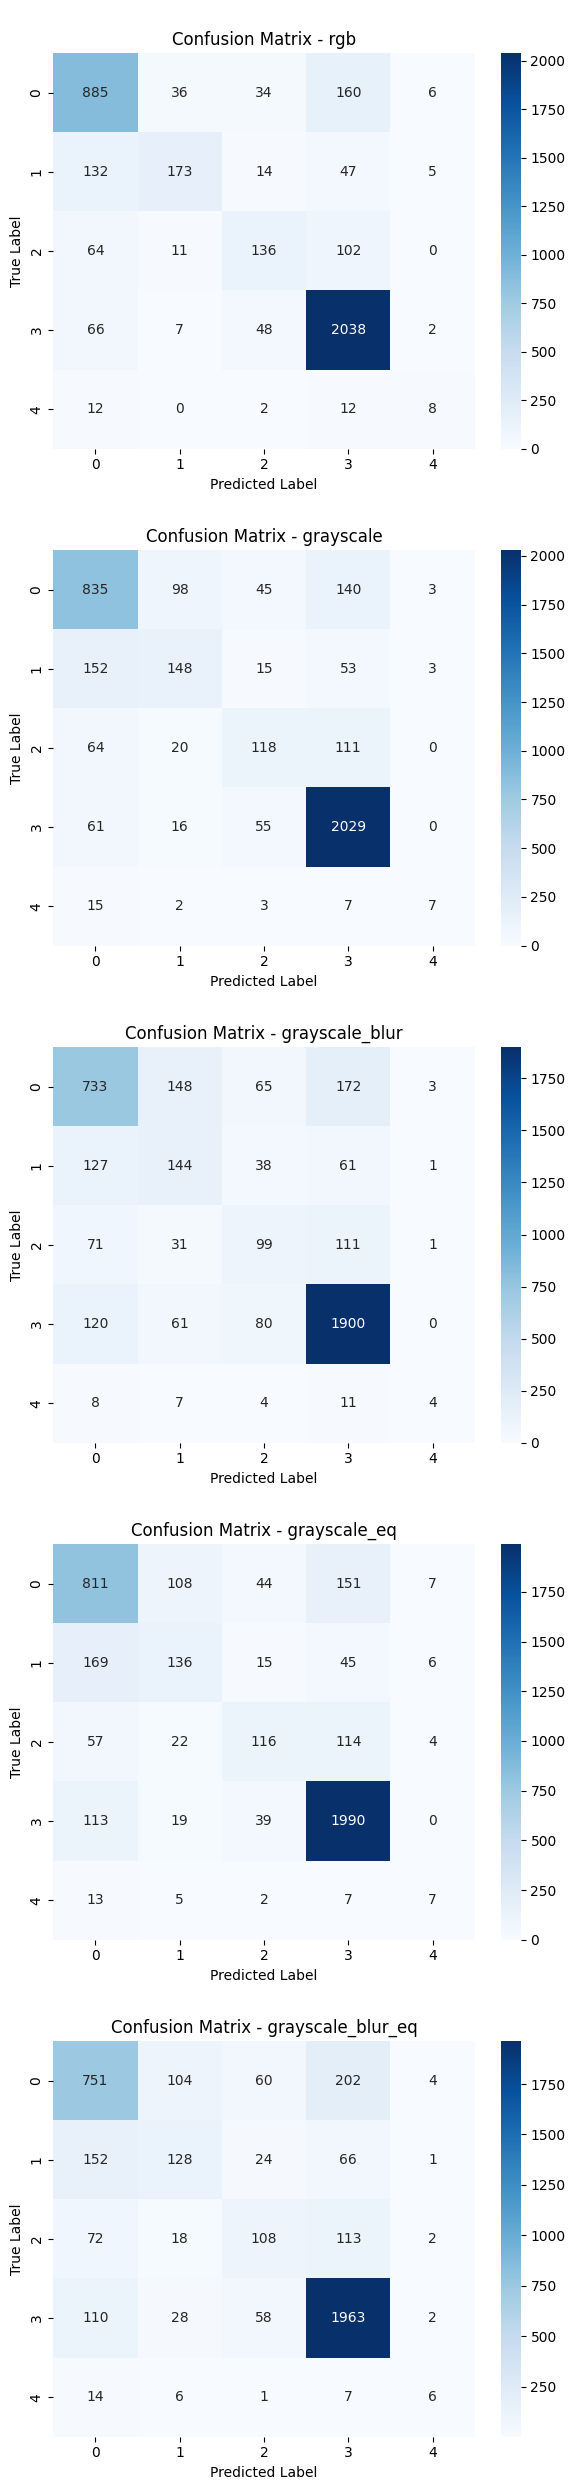

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

methods_list = list(results.keys())
num_methods = len(methods_list)

fig, axes = plt.subplots(nrows=num_methods, ncols=1, figsize=(6, 5 * num_methods))  # height * num_methods

if num_methods == 1:
    axes = [axes]  # ensure axes is iterable even if one plot

for ax, method in zip(axes, methods_list):
    cm = results[method]['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f"\nConfusion Matrix - {method}")
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

plt.tight_layout()
plt.show()

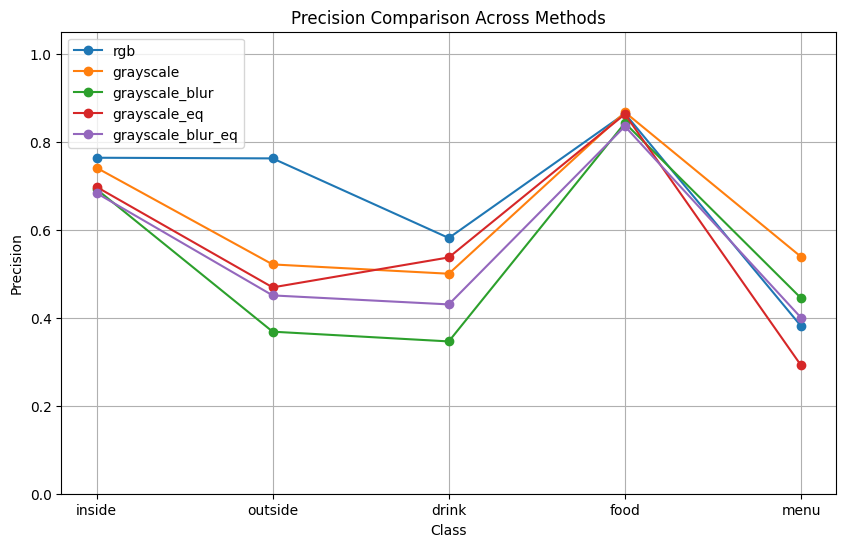

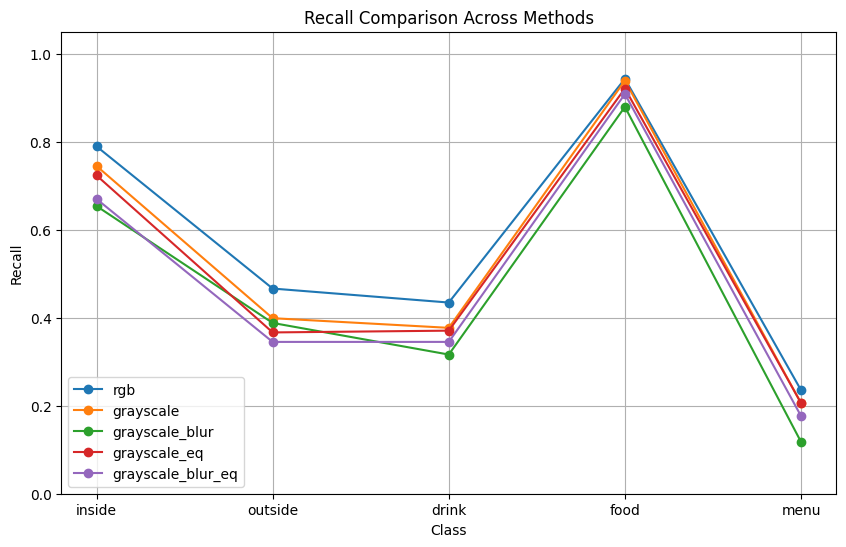

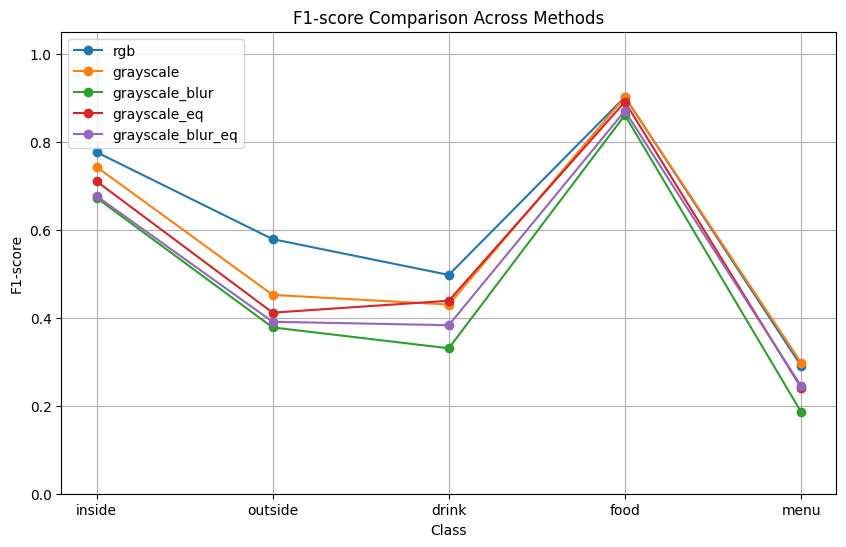

In [85]:
def plot_classification_metrics(report_dicts, label_names):
    metrics = ['precision', 'recall', 'f1-score']
    methods = list(report_dicts.keys())

    for metric in metrics:
        plt.figure(figsize=(10,6))
        for method in methods:
            values = [report_dicts[method][label][metric] for label in label_names]
            plt.plot(label_names, values, marker='o', label=method)
        plt.title(f'{metric.capitalize()} Comparison Across Methods')
        plt.ylabel(metric.capitalize())
        plt.xlabel('Class')
        plt.ylim(0, 1.05)
        plt.legend()
        plt.grid(True)
        plt.show()

# After running all models, call:
plot_classification_metrics(report_dicts, label_names=list(label_dict.keys()))